# **Construction of machine learning models using ECFP6 fingerprints extracted from SMILES of HSP90 inhibitors**


#### **This script is designed to construct a regression model for the dissociation rate constant of HSP90 inhibitors using ECFP6 molecular fingerprint features. The objective is to develop a Quantitative Structure-Kinetics Relationship (QSKR) model to predict the dissociation rate constants for 132 HSP90 inhibitors and elucidate the contributions of significant molecular features. In the script, we compare two machine learning algorithms: Extreme Gradient Boosting (XGBoost) and Support Vector Machine Regression (SVR).**

#### Author:  Chao Xu
#### Contact:  
E-Mail: xuchao2@shanghaitech.edu.cn
#### Python libraries requared:
pandas <br>
scikit-learn <br>
numpy <br>
python <br>
matplotlib <br>

# ECFP6 XGBoost Model
## 1. Load the required modules

In [21]:
from sklearn.model_selection import KFold,cross_val_score as CVS,train_test_split as TTS
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor as XGBR
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import pandas as pd
import numpy as np
import pickle
import math

## 2. Feature selection threshold exploration:

The purpose of this code is to explore the impact of feature selection on the performance of an XGBoost regression model. The plot generated at the end helps to identify an optimal threshold for feature selection based on cross-validated performance.

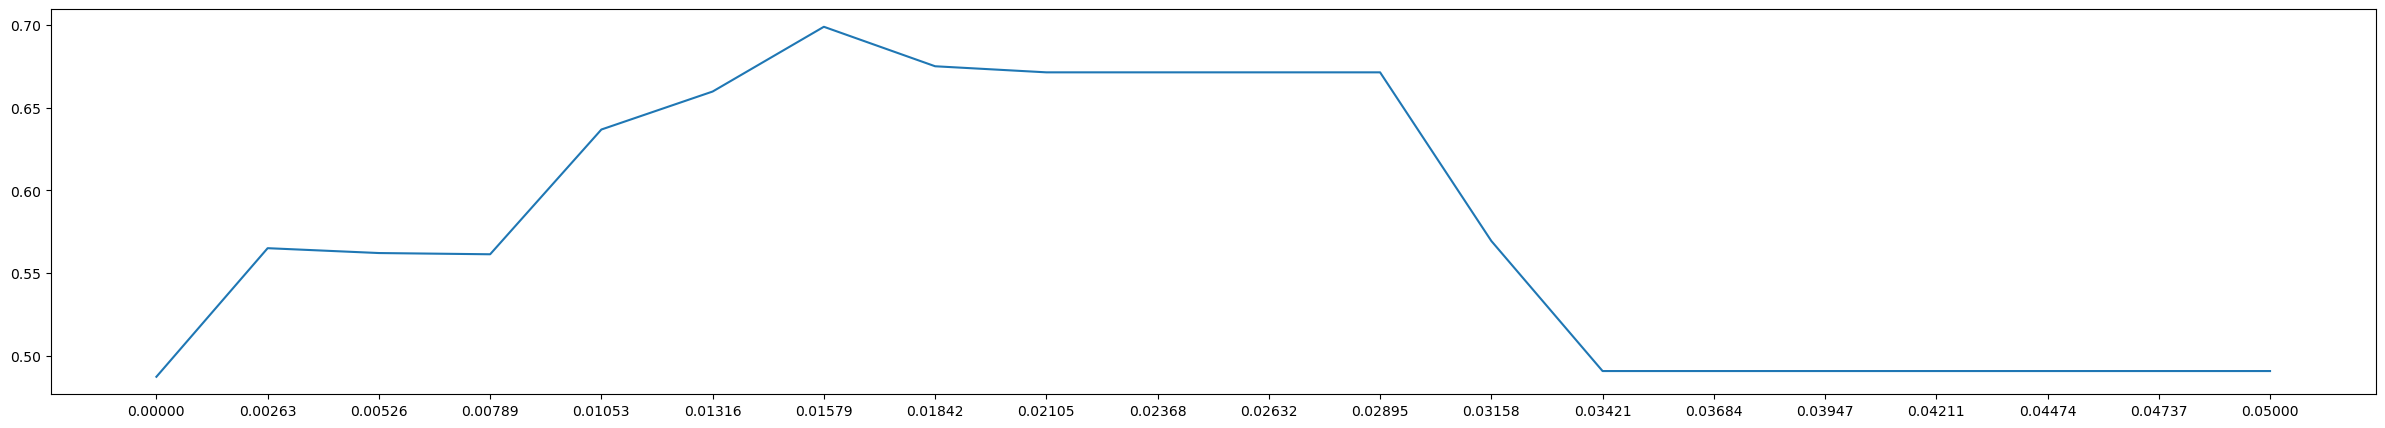

In [22]:
# Load data
data_path = r"D:\jupyter notebook\HSP90\ML\data\ECFP6-fingerprint.csv"
data = pd.read_csv(data_path)
X = data.iloc[:, 2:]
Y = data.iloc[:, 1]

# Split data
X_train_split, X_test_split, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=420)

# Feature scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_split)
X_test = scaler.fit_transform(X_test_split)

# Model initialization
reg_1 = XGBR(n_estimators=150, random_state=420)

# Feature selection threshold
threshold = np.linspace(0, 0.05, 20)

# Evaluate model performance for different thresholds
scores = []
for t in threshold:
    X_embedded = SelectFromModel(reg_1, threshold=t).fit_transform(X_train, Y_train)
    score = CVS(reg_1, X_embedded, Y_train, cv=5).mean()
    scores.append(score)

# Plot the results
plt.figure(figsize=[30, 5])
plt.plot(threshold, scores)
plt.xticks(np.linspace(0, 0.05, 20))
plt.show()

## 3. Feature selection and feature importance analysis

     Feature  Importance
1991    1992    0.254808
1152    1153    0.198435
283      284    0.053104
55        56    0.033104
1019    1020    0.032874
61        62    0.030826
1602    1603    0.030461
935      936    0.030065
586      587    0.029263
456      457    0.018962


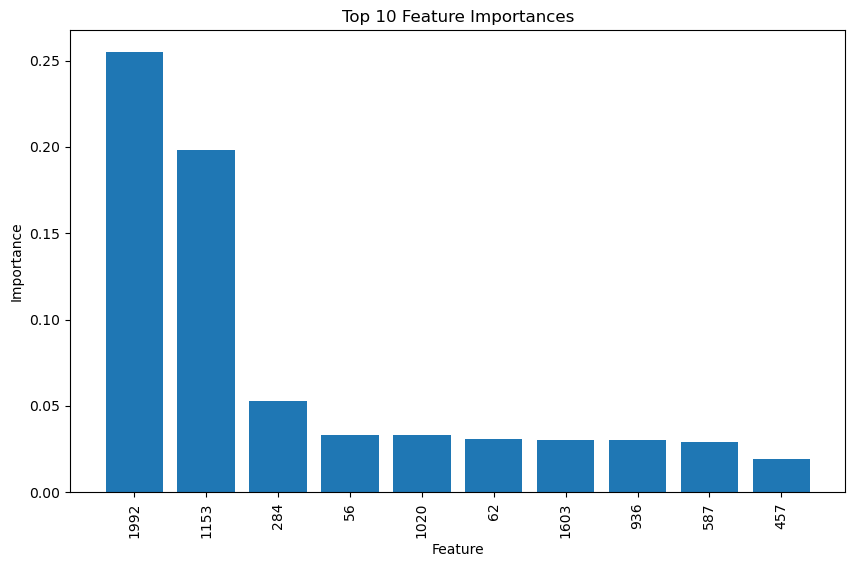

In [4]:
# Feature selection
reg = XGBR(n_estimators=150, random_state=420)
x_select_train = SelectFromModel(reg, threshold=0.01579).fit_transform(X_train, Y_train)

# Train XGBoost model
reg = XGBR(n_estimators=150, random_state=420)
reg.fit(X_train, Y_train)

# Get feature importances
feature_importances = reg.feature_importances_

# Get feature names
feature_names = X_train_split.columns

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display or save the sorted feature importances
print(feature_importance_df.head(10))  # Display the top 10 features

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(10), feature_importance_df.head(10)['Importance'], align='center')
plt.xticks(range(10), feature_importance_df.head(10)['Feature'], rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.show()


## 4. Grid search for model tuning
The overall purpose of this code is to perform feature selection, tune hyperparameters using grid search, and train an XGBoost regression model on the selected features

In [5]:
# Parameter grid for XGBoost
param_grid = {
    'n_estimators': [80, 90, 100, 110, 120, 130, 140, 150],
    'learning_rate': [0.01, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.5, 1, 2],
    'max_depth': [3,4,5,6,7]
}

# Grid search using XGBoost
grid_search = GridSearchCV(estimator=XGBR(random_state=420),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
grid_result = grid_search.fit(x_select_train, Y_train)

best_params = grid_result.best_params_
best_model = grid_result.best_estimator_

# Train the best model on the entire training set
best_model.fit(x_select_train, Y_train)

# Make predictions on the training set
train_predictions = best_model.predict(x_select_train)

# Evaluate the model on the training set
r2_train = r2_score(Y_train, train_predictions)
mae_train = mean_absolute_error(Y_train, train_predictions)

print('Best Parameters:', best_params)
print('R2 on Training Set:', r2_train)
print('MAE on Training Set:', mae_train)

Best Parameters: {'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 80}
R2 on Training Set: 0.8709411495653749
MAE on Training Set: 0.2613600710683368


### Here we will build a learing curves for our model

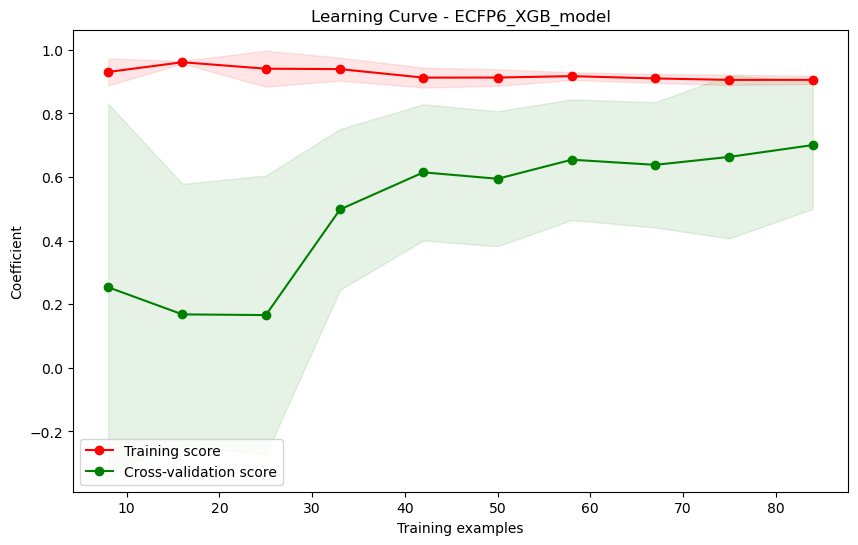

In [25]:
def plot_learning_curve(estimator, X, y, train_sizes, cv, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Coefficient")

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    
# Define XGBoost model parameters
opti_params = {'n_estimators': 80, 'learning_rate': 0.07, 'max_depth': 4, 'gamma': 0, 'min_child_weight': 2,
               'seed': 0, 'subsample': 1, 'colsample_bytree': 1, 'reg_alpha': 0, 'reg_lambda': 1}

# Initialize XGBoost model
ECFP6_Fingerprints_XGB_model = XGBR(**opti_params, random_state=420)

# Feature selection
x_select = SelectFromModel(ECFP6_Fingerprints_XGB_model, threshold=0.01579).fit_transform(X_train, Y_train)

# Plot learning curve
plot_learning_curve(ECFP6_Fingerprints_XGB_model, x_select, Y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
                    title="Learning Curve - ECFP6_XGB_model")

## 5. Model construction and prediction on the test set.
Here, we performed 10 random splits of the dataset, trained the models using leave-one-out cross-validation on the training set, and tested each model on the corresponding test set

In [26]:
# Parameter settings
num_iterations = 10
threshold_value = 0.01579

# Initialize lists to store results
results_list = []
models_list = []
selected_features_list = []

# Iterate to train models
for i, random_state in enumerate(range(420, 420 + num_iterations * 30, 30)):
    # Random train-test split
    X_train_split, X_test_split, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train_split)
    X_test = scaler.transform(X_test_split)
    
    # Initialize XGBoost model
    xgb_model = XGBR(n_estimators=80, learning_rate=0.07, max_depth=4, gamma=0,
                     min_child_weight=2, seed=0, subsample=1, colsample_bytree=1,
                     reg_alpha=0, reg_lambda=1, random_state=420)

    # Feature selection
    x_select = SelectFromModel(xgb_model, threshold=threshold_value).fit_transform(X_train, Y_train)

    # Leave-One-Out training
    random_split_results = []
    for train_index_loo, test_index_loo in LeaveOneOut().split(x_select):
        x_train_loo, x_test_loo, y_train_loo, y_test_loo = x_select[train_index_loo], x_select[test_index_loo], \
                                                           Y_train.iloc[train_index_loo], Y_train.iloc[test_index_loo]
        xgb_model.fit(x_train_loo, y_train_loo)
        random_split_results.append((y_test_loo.tolist()[0], xgb_model.predict(x_test_loo).tolist()[0]))

    results_list.append(random_split_results)
    models_list.append(xgb_model)

    # Store selected features for this fold
    X_embedded = SelectFromModel(xgb_model, threshold=threshold_value).fit(X_train, Y_train)
    selected_features_list.append(X_embedded.get_support())

    # Save the model
    model_filename = f'ECFP6_XGB_model_iteration_{i}.dat'
    with open(model_filename, 'wb') as model_file:
        pickle.dump(xgb_model, model_file)

# Save training results
with open('ECFP6_XGB_results_training_random_splits.pkl', 'wb') as f:
    pickle.dump(results_list, f)

# Save model filenames
with open('model_filenames_random_splits.pkl', 'wb') as f:
    pickle.dump([f'ECFP6_XGB_model_iteration_{i}.dat' for i in range(len(models_list))], f)

# Save selected features
with open('ECFP6_XGB_selected_features_random_splits.pkl', 'wb') as f:
    pickle.dump(selected_features_list, f)

# Load model filenames
with open('model_filenames_random_splits.pkl', 'rb') as f:
    model_filenames = pickle.load(f)

# Test set results
results_test_list = []
for i, model_filename in enumerate(model_filenames):
    # Load the trained model
    with open(model_filename, 'rb') as model_file:
        loaded_model = pickle.load(model_file)

    # Use the same features selected during training for testing
    selected_features = selected_features_list[i]
    x_test_select = X_test[:, selected_features]

    # Predictions
    predictions = loaded_model.predict(x_test_select)

    # Append results to the list
    results_test_list.append(list(zip(Y_test.tolist(), predictions)))

# Save test results
with open('ECFP6_XGB_results_test_random_splits.pkl', 'wb') as f:
    pickle.dump(results_test_list, f)

## 6. Evaluating model performance and visualizing prediction results.

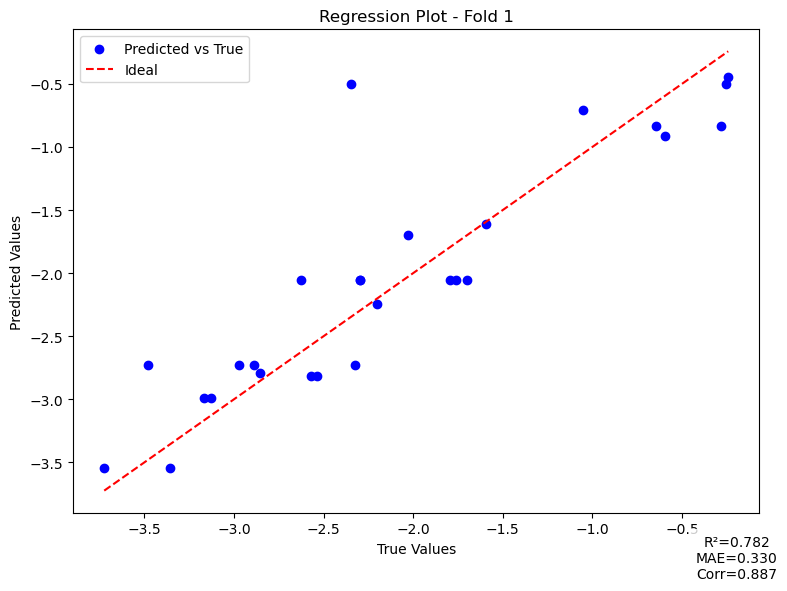

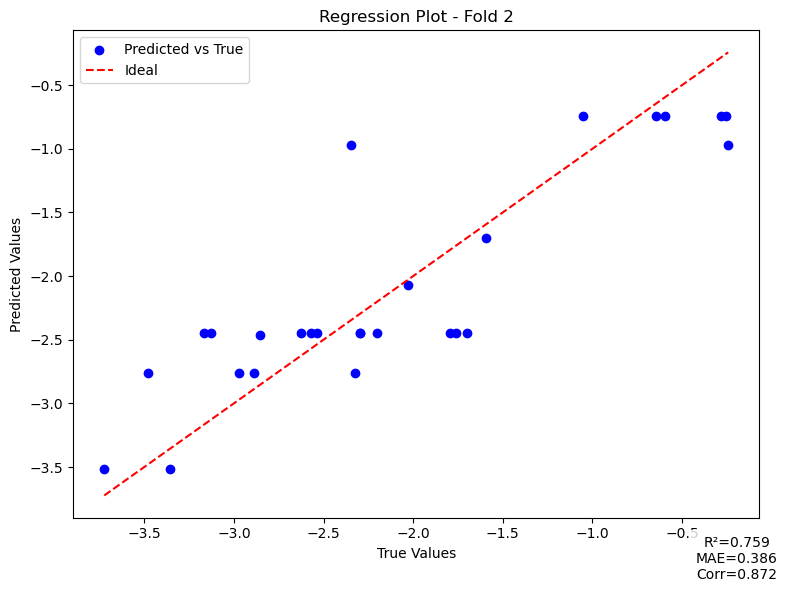

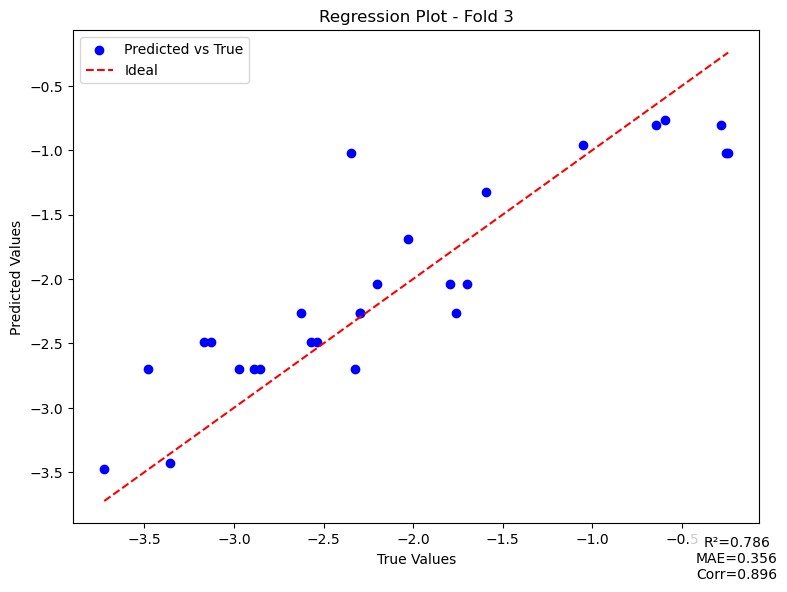

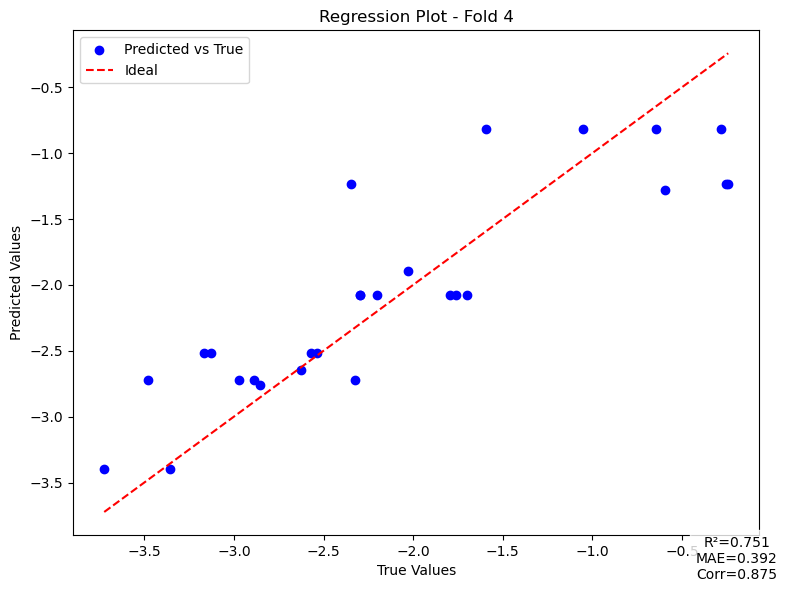

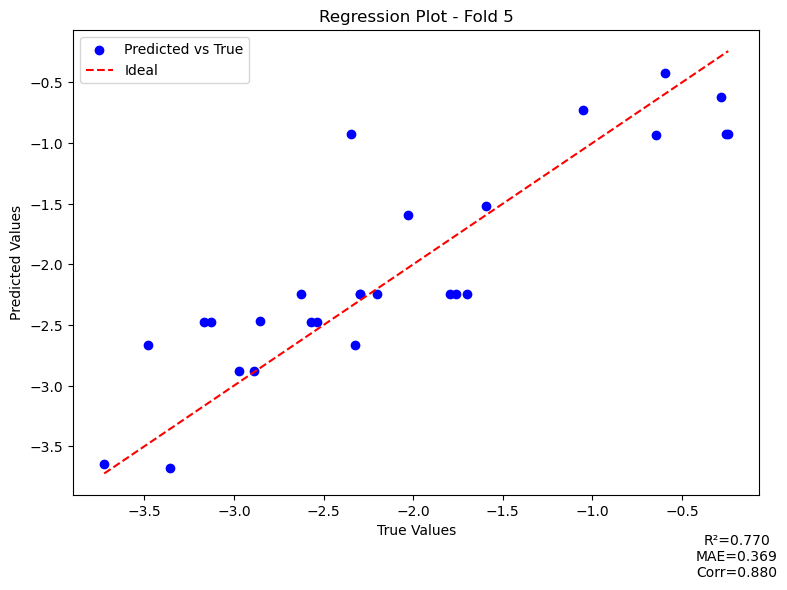

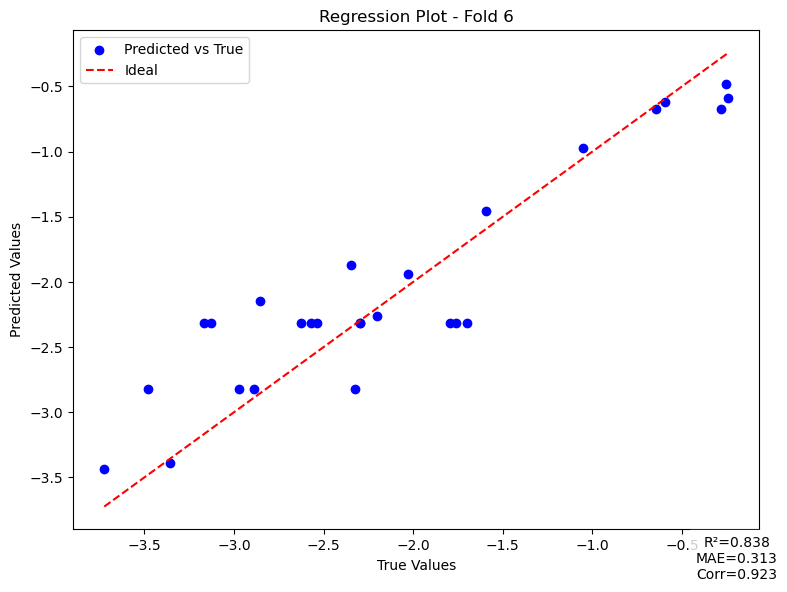

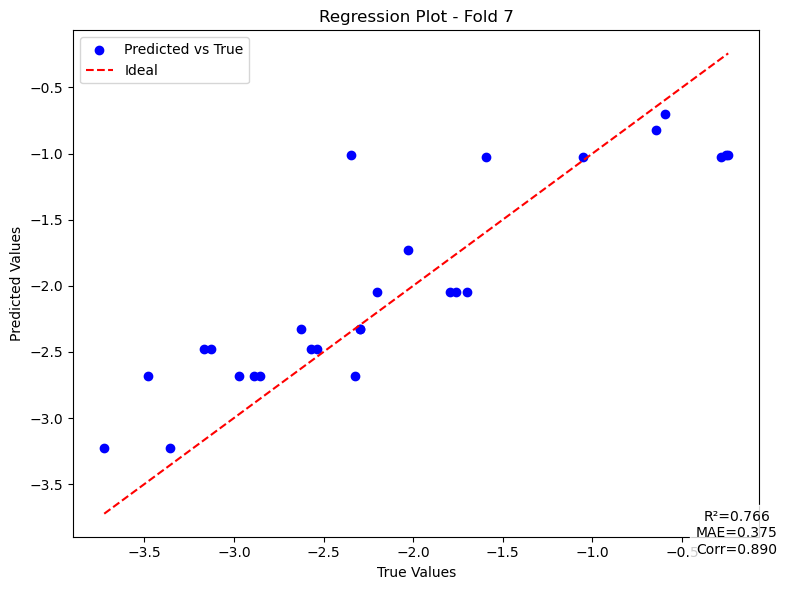

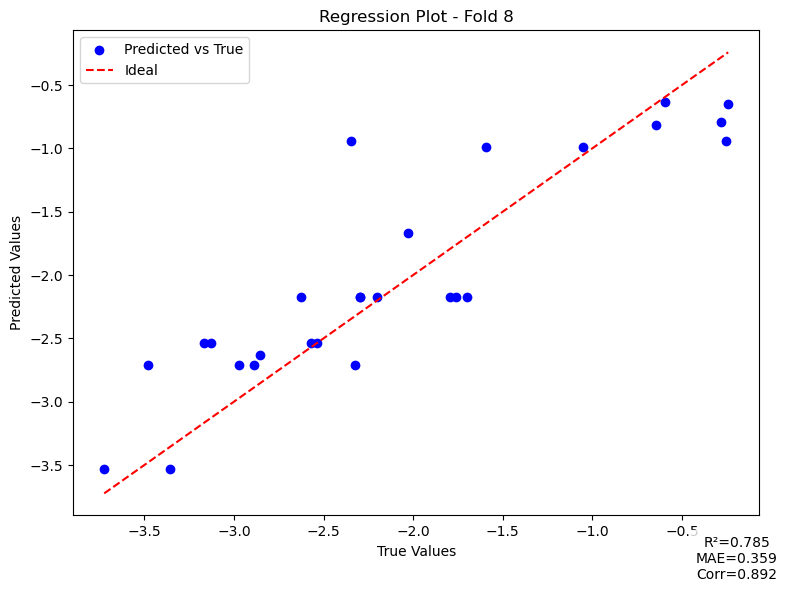

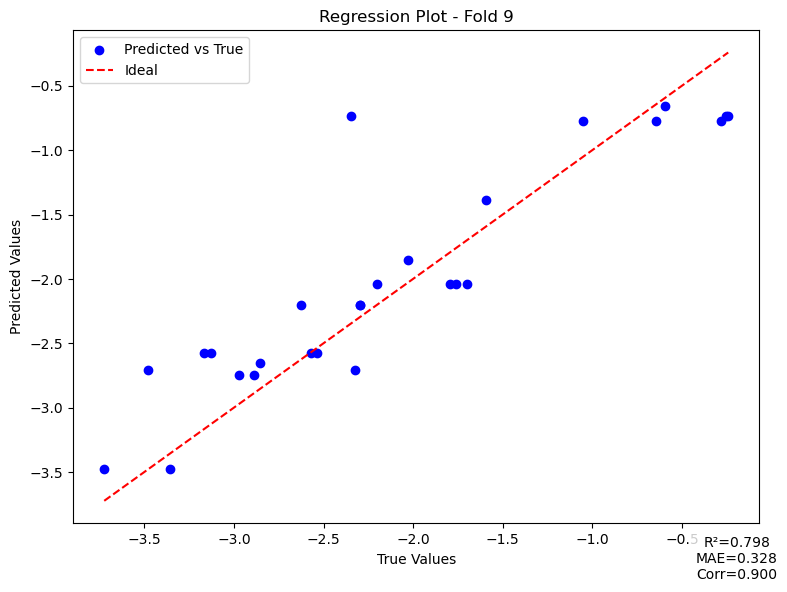

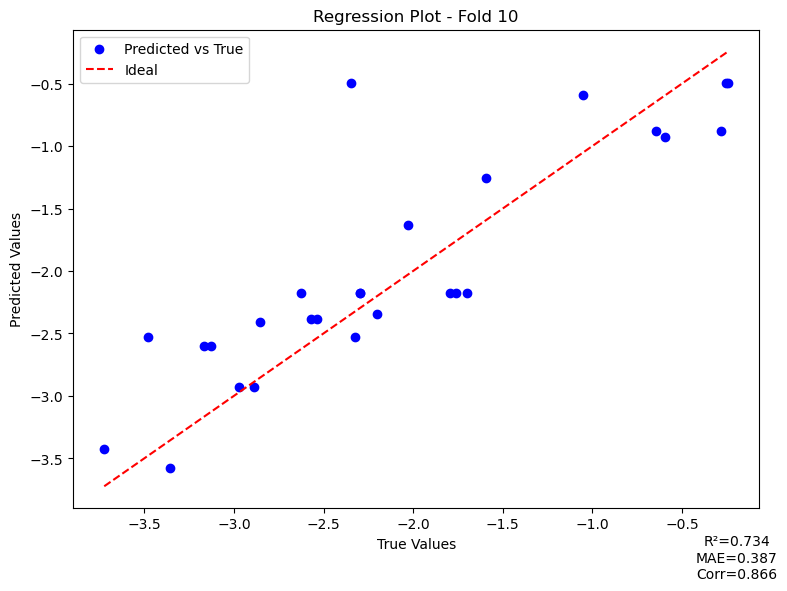

Mean R²: 0.777, Std R²: 0.027
Mean MAE: 0.359, Std MAE: 0.026
Mean Correlation Coefficient: 0.888, Std Correlation Coefficient: 0.016


In [27]:
# Load the results_list from the saved file
with open('ECFP6_XGB_results_test_random_splits.pkl', 'rb') as f:
    results_list = pickle.load(f)

# Lists to store performance metrics for each fold
r_squared_list = []
mae_list = []
corr_coefficient_list = []

# Plot regression graphs for each fold
for fold, results in enumerate(results_list):
    true_values, predicted_values = zip(*results)

    # Calculate R², MAE, and Pearson correlation coefficient
    r_squared = r2_score(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    corr_coefficient = np.corrcoef(true_values, predicted_values)[0, 1]

    # Append metrics to lists for later analysis
    r_squared_list.append(r_squared)
    mae_list.append(mae)
    corr_coefficient_list.append(corr_coefficient)

    # Plot regression graph
    plt.figure(figsize=(8, 6))
    plt.scatter(true_values, predicted_values, color='blue', label='Predicted vs True')
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], linestyle='--', color='red', label='Ideal')

    # Annotate the plot with performance metrics
    text_x = max(true_values) * 0.8
    text_y = min(predicted_values) * 1.2
    plt.text(text_x, text_y, f'R²={r_squared:.3f}\nMAE={mae:.3f}\nCorr={corr_coefficient:.3f}',
             ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

    plt.title(f'Regression Plot - Fold {fold + 1}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.tight_layout()  # Ensure tight layout to prevent clipping of labels
    plt.show()

# Calculate mean and standard deviation for R², MAE, and Pearson correlation coefficient
mean_r_squared = np.mean(r_squared_list)
std_r_squared = np.std(r_squared_list)

mean_mae = np.mean(mae_list)
std_mae = np.std(mae_list)

mean_corr_coefficient = np.mean(corr_coefficient_list)
std_corr_coefficient = np.std(corr_coefficient_list)

# Print or use the calculated values as needed
print(f'Mean R²: {mean_r_squared:.3f}, Std R²: {std_r_squared:.3f}')
print(f'Mean MAE: {mean_mae:.3f}, Std MAE: {std_mae:.3f}')
print(f'Mean Correlation Coefficient: {mean_corr_coefficient:.3f}, Std Correlation Coefficient: {std_corr_coefficient:.3f}')

# ECFP6 SVR Model
## 1. Feature selection threshold exploration:

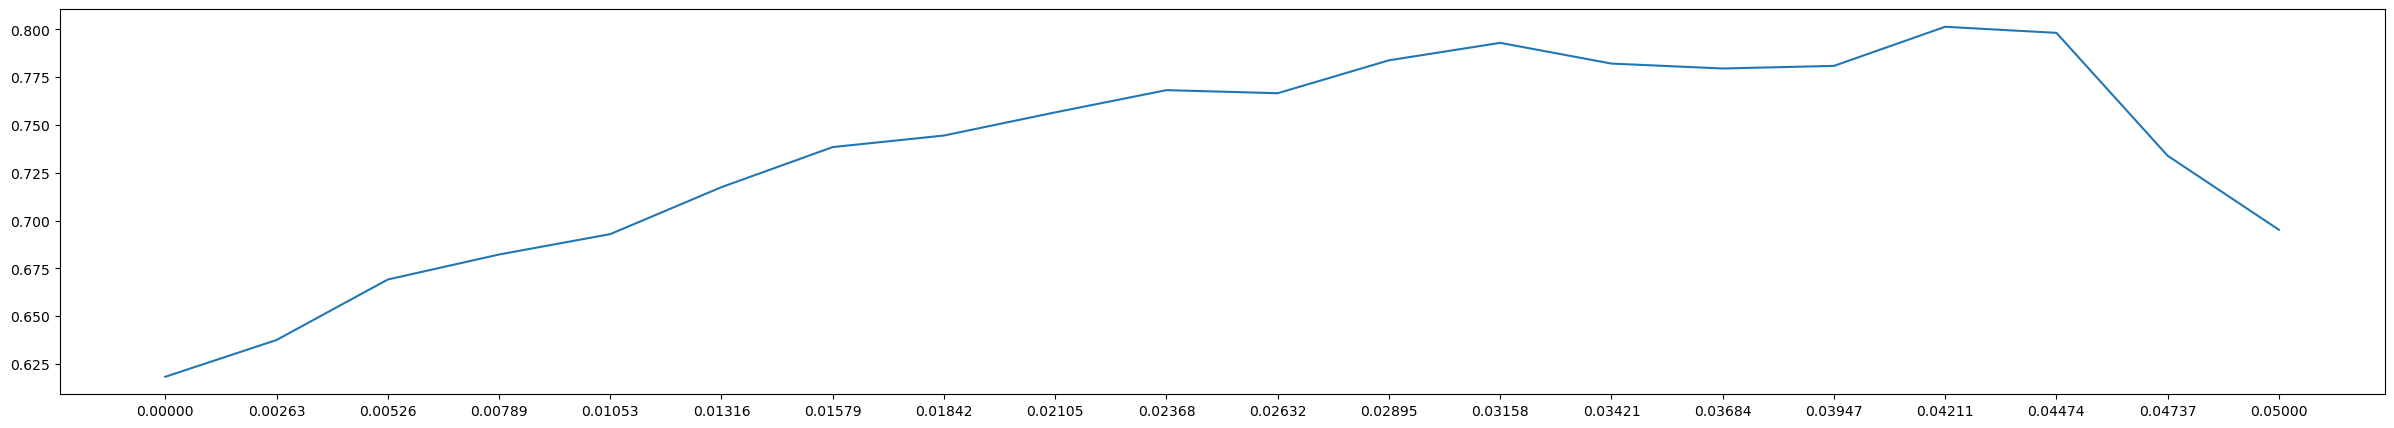

In [15]:
# Load data
data_path = r"D:\jupyter notebook\HSP90\ML\data\ECFP6-fingerprint.csv"
data = pd.read_csv(data_path)
X = data.iloc[:, 2:]
Y = data.iloc[:, 1]

# Split data
X_train_split, X_test_split, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=420)

# Feature scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_split)
X_test = scaler.fit_transform(X_test_split)

def feature_selection_and_cv(model, X_train, Y_train, threshold_values):
    scores = []

    for threshold in threshold_values:
        # Feature selection
        model.fit(X_train, Y_train)  # Fit the SVR model here
        x_select = SelectFromModel(model, threshold=threshold).fit_transform(X_train, Y_train)

        # Cross-validation
        once_score = CVS(model, x_select, Y_train, cv=5).mean()
        scores.append(once_score)

    return scores

# Feature selection and cross-validation using the entire training set
threshold_values_svr = np.linspace(0, 0.05, 20)
svr_model = SVR(kernel='linear')  # Choose the kernel based on your needs
scores_svr = feature_selection_and_cv(svr_model, X_train, Y_train, threshold_values_svr)

# Plot the results
plt.figure(figsize=[30, 5])
plt.plot(threshold_values_svr, scores_svr)
plt.xticks(threshold_values_svr)
plt.show()

## 2. Feature selection and feature importance analysis

     Feature  Importance
1057    1058    0.146877
1991    1992    0.124291
1904    1905    0.122396
1602    1603    0.120129
699      700    0.118481
1928    1929    0.117377
381      382    0.115088
233      234    0.111177
992      993    0.109092
1152    1153    0.106843


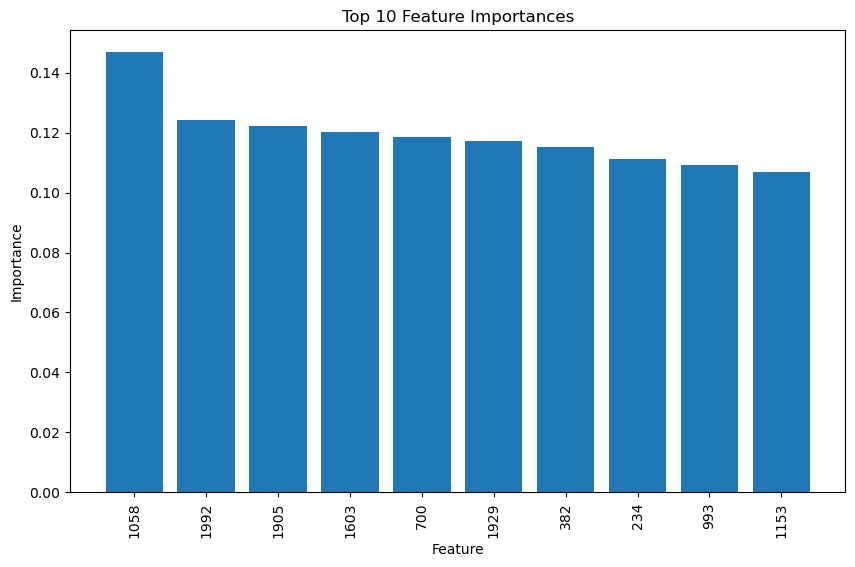

In [16]:
# Train SVR model
svr_model = SVR(kernel='linear')
svr_model.fit(X_train, Y_train)

# Get feature coefficients
feature_coefficients = np.abs(svr_model.coef_[0])

# Get feature names
feature_names = X_train_split.columns

# Create a DataFrame to store feature names and their coefficients
feature_coefficient_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_coefficients})

# Sort the DataFrame by coefficient magnitude in descending order
feature_coefficient_df = feature_coefficient_df.reindex(
    feature_coefficient_df['Importance'].abs().sort_values(ascending=False).index
)

# Display or save the sorted feature coefficients
print(feature_coefficient_df.head(10))  # Display the top 10 features

# Plot feature coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(10), feature_coefficient_df.head(10)['Importance'], align='center')
plt.xticks(range(10), feature_coefficient_df.head(10)['Feature'], rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.show()


## 3. Grid search for model tuning

In [17]:
# Feature selection using SVR
svr_model = SVR(kernel='linear')
x_select_train = SelectFromModel(svr_model, threshold=0.04211).fit_transform(X_train, Y_train)

# Parameter grid for XGBoost
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 2],
              'gamma': [0.001, 0.01, 0.015, 0.02, 0.03, 0.04, 0.05,1, 2]}

# Grid search using SVR for parameter tuning
grid_search = GridSearchCV(estimator=SVR(),
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
grid_result = grid_search.fit(x_select_train, Y_train)

best_params = grid_result.best_params_
best_model = grid_result.best_estimator_

# Train the best model on the entire training set
best_model.fit(x_select_train, Y_train)

# Make predictions on the training set
train_predictions = best_model.predict(x_select_train)

# Evaluate the model on the training set
r2_train = r2_score(Y_train, train_predictions)
mae_train = mean_absolute_error(Y_train, train_predictions)

print('最佳参数为：', best_params)

最佳参数为： {'C': 2, 'gamma': 0.03}


### Here we will build a learing curves for our model

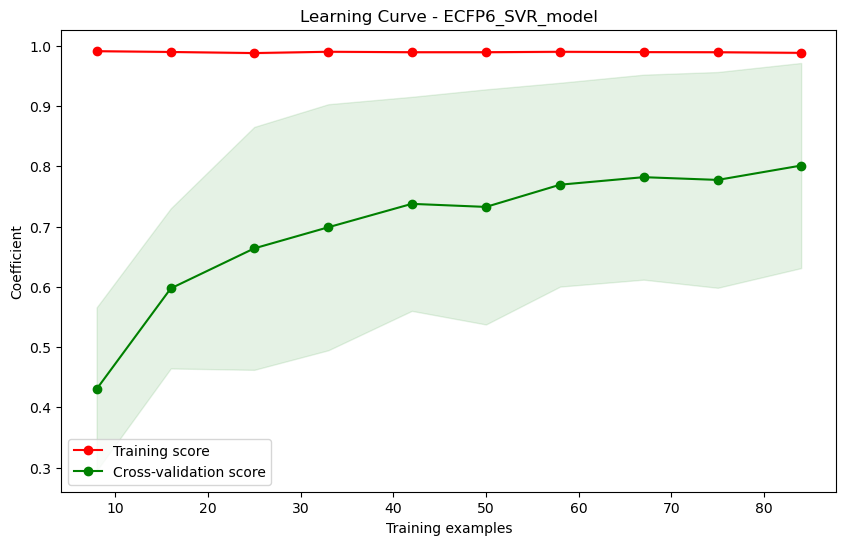

In [18]:
def plot_learning_curve(estimator, X, y, train_sizes, cv, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Coefficient")

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
# Define SVR model parameters
svr_params = {'kernel': 'linear', 'C': 2, 'gamma': 0.03}

# Initialize SVR model
ECFP6_SVR_model = SVR(**svr_params)

# Feature selection
x_select = SelectFromModel(ECFP6_SVR_model, threshold=0.04211).fit_transform(X_train, Y_train)

# Plot learning curve
plot_learning_curve(ECFP6_SVR_model, x_select, Y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10),
                    title="Learning Curve - ECFP6_SVR_model")

## 4. Model construction and prediction on the test set.

In [19]:
# Define the number of iterations
num_iterations = 10
threshold_value = 0.04211

# Initialize lists to store results
results_list = []
models_list = []
selected_features_list = []

# Iterate over the random train-test splits
for i in range(num_iterations):
    # Set a different random state for each iteration
    random_state = 420 + i * 30

    # Perform random train-test split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

    # Initialize SVR model
    ECFP6_fingerprints_svr_model = SVR(kernel='linear', C=2, gamma=0.03)

    # Feature selection
    x_select = SelectFromModel(ECFP6_fingerprints_svr_model, threshold=threshold_value).fit_transform(X_train, Y_train)

    random_split_results = []

    # Leave-One-Out training
    for train_index_loo, test_index_loo in LeaveOneOut().split(x_select):
        x_train_loo, x_test_loo, y_train_loo, y_test_loo = x_select[train_index_loo], x_select[test_index_loo], \
                                                           Y_train.iloc[train_index_loo], Y_train.iloc[test_index_loo]
        ECFP6_fingerprints_svr_model.fit(x_train_loo, y_train_loo)
        random_split_results.append((y_test_loo.tolist()[0], ECFP6_fingerprints_svr_model.predict(x_test_loo).tolist()[0]))

    results_list.append(random_split_results)
    models_list.append(ECFP6_fingerprints_svr_model)

    # Store selected features for this fold
    X_embedded = SelectFromModel(ECFP6_fingerprints_svr_model, threshold=threshold_value).fit(X_train, Y_train)
    selected_features_list.append(X_train.columns[X_embedded.get_support()])

    # Save the model for this iteration
    model_filename = f'ECFP6_Fingerprints_svr_model_iteration_{i}.dat'
    with open(model_filename, 'wb') as model_file:
        pickle.dump(ECFP6_fingerprints_svr_model, model_file)

# Save results to a file
with open('ECFP6_Fingerprints_svr_model_results_training_random_splits.pkl', 'wb') as f:
    pickle.dump(results_list, f)

# Save model filenames to a file
with open('model_filenames_random_splits.pkl', 'wb') as f:
    pickle.dump([f'ECFP6_Fingerprints_svr_model_iteration_{i}.dat' for i in range(len(models_list))], f)

# Save selected features to a file
with open('ECFP6_SVR_selected_features_random_splits.pkl', 'wb') as f:
    pickle.dump(selected_features_list, f)

# Load model filenames
with open('model_filenames_random_splits.pkl', 'rb') as f:
    model_filenames = pickle.load(f)

results_test_list = []

# Iterate over the iterations
for i in range(num_iterations):
    # Load the trained model
    with open(model_filenames[i], 'rb') as model_file:
        loaded_model = pickle.load(model_file)

    # Use the same features selected during training for testing
    selected_features = selected_features_list[i]
    x_test_select = X_test[selected_features]

    # Make predictions
    predictions = loaded_model.predict(x_test_select)

    # Append results to the list
    results_test_list.append(list(zip(Y_test.tolist(), predictions)))

# Save results to a file
with open('ECFP6_Fingerprints_svr_model_results_test_random_splits.pkl', 'wb') as f:
    pickle.dump(results_test_list, f)


D:\Software\Anaconda\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
D:\Software\Anaconda\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
D:\Software\Anaconda\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
D:\Software\Anaconda\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
D:\Software\Anaconda\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
D:\Software\Anaconda\anaconda\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
D:\Software\Anaconda\anaconda\Lib\

## 5. Evaluating model performance and visualizing prediction results.

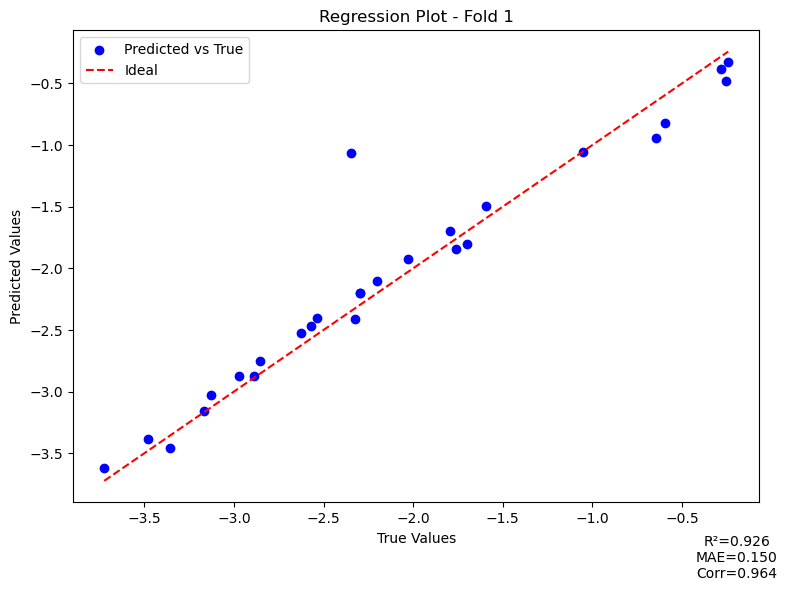

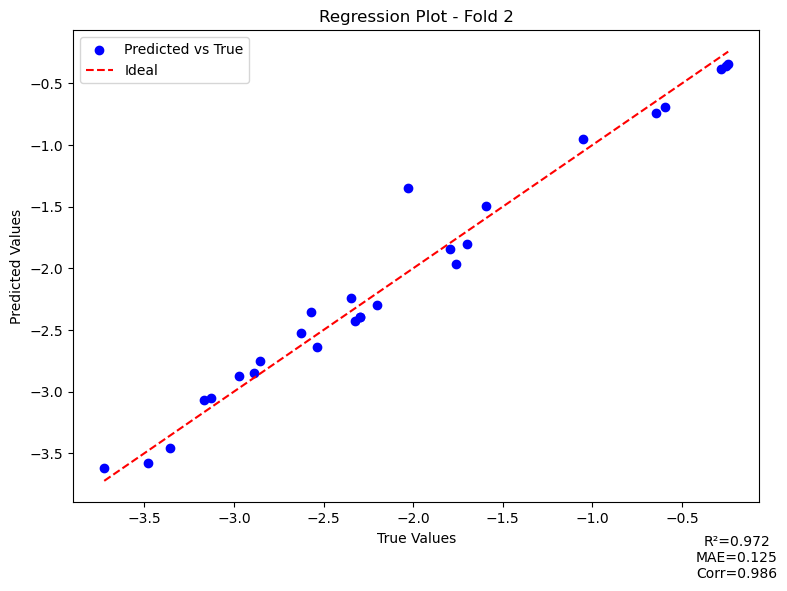

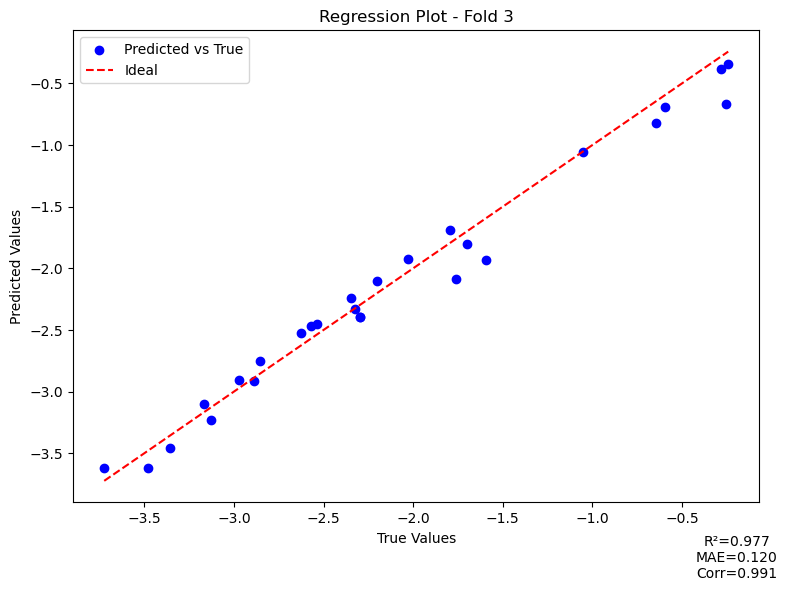

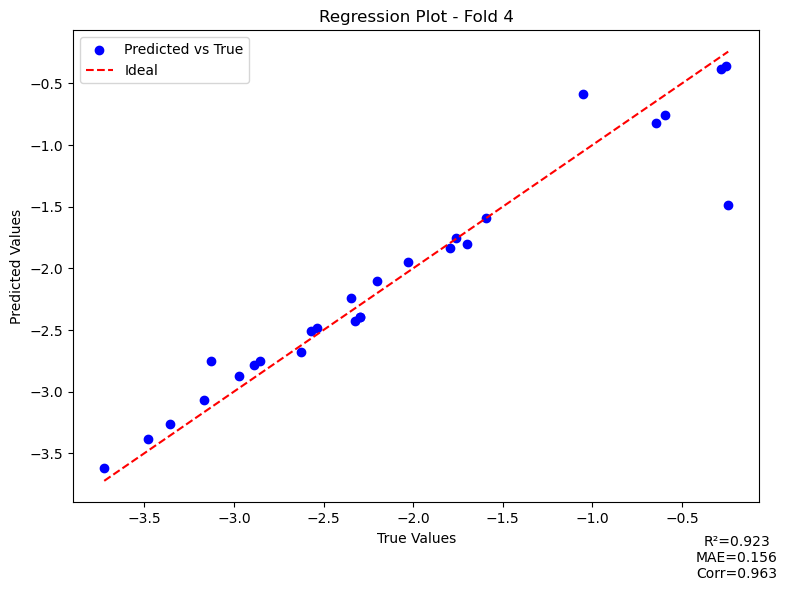

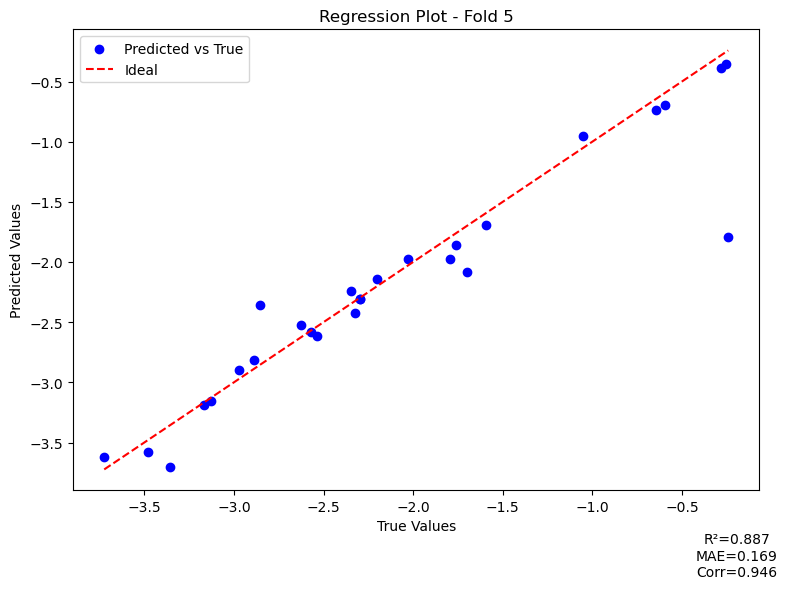

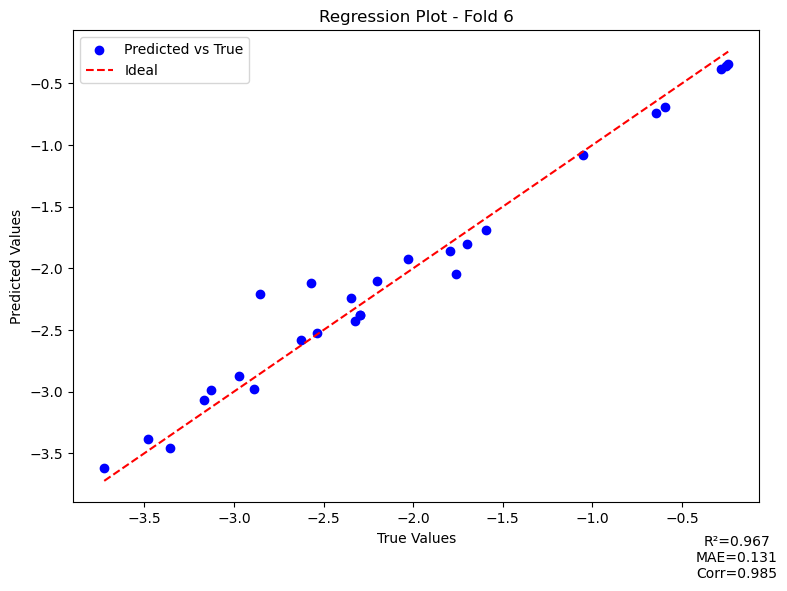

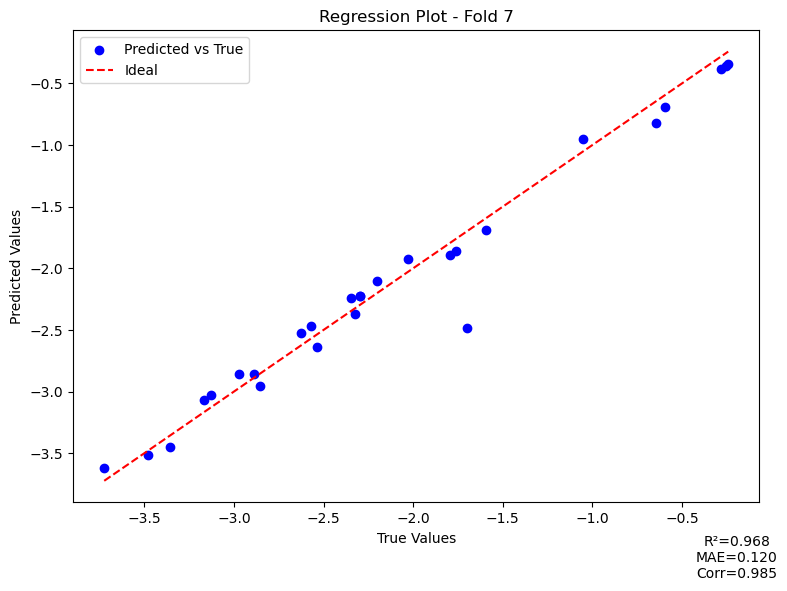

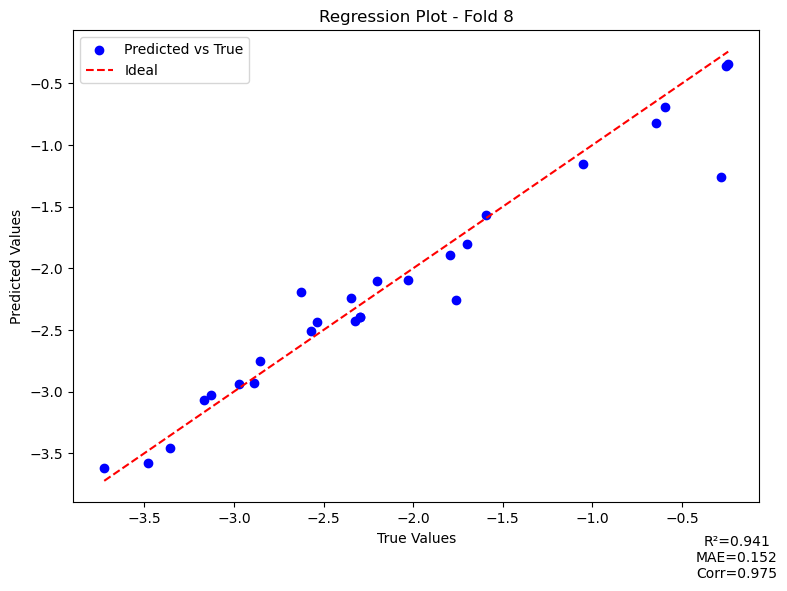

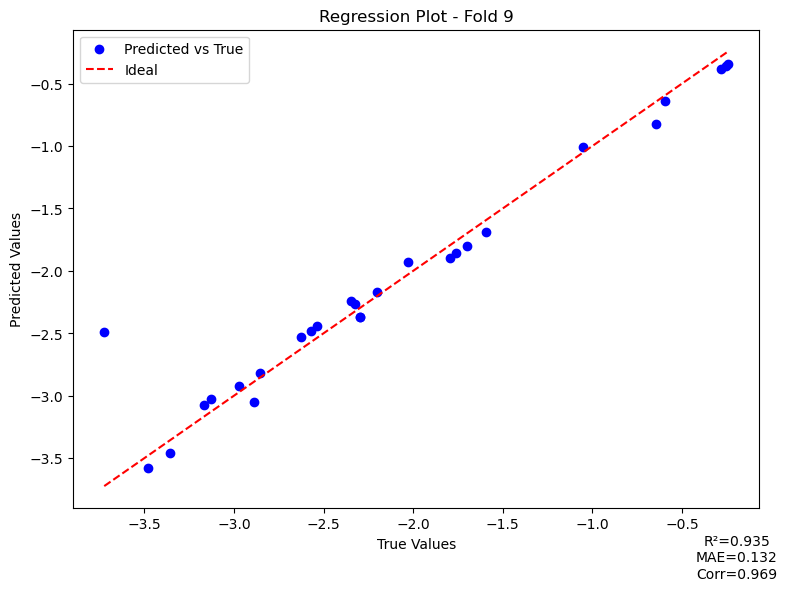

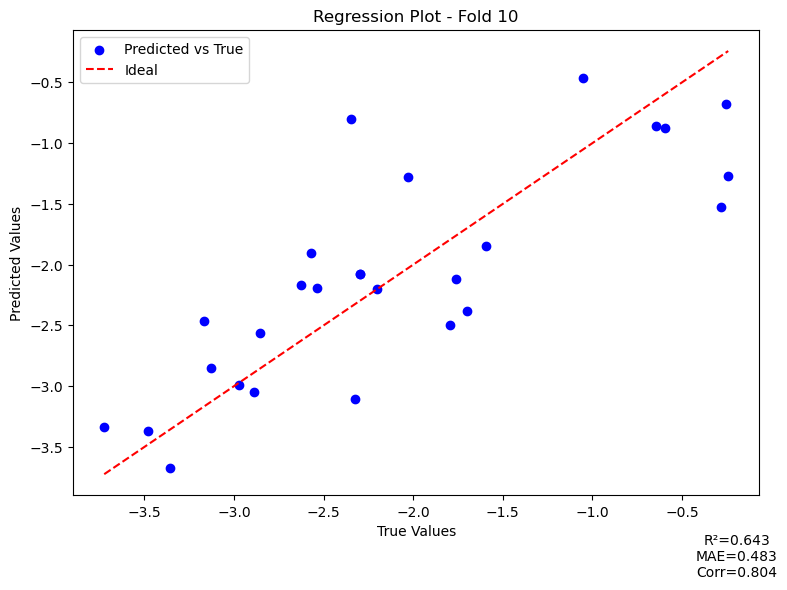

Mean R²: 0.914, Std R²: 0.094
Mean MAE: 0.174, Std MAE: 0.104
Mean corr_coefficient: 0.957, Std MAE: 0.052


In [20]:
# Load the results_list from the saved file
with open('ECFP6_Fingerprints_svr_model_results_test_random_splits.pkl', 'rb') as f:
    results_list = pickle.load(f)

r_squared_list = []
mae_list = []
corr_coefficient_list = []
# Plot regression graphs for each fold
for fold, results in enumerate(results_list):
    true_values, predicted_values = zip(*results)

    # Calculate R², MAE, and Pearson correlation coefficient
    r_squared = r2_score(true_values, predicted_values)
    mae = mean_absolute_error(true_values, predicted_values)
    corr_coefficient = np.corrcoef(true_values, predicted_values)[0, 1]
    
    r_squared_list.append(r_squared)
    mae_list.append(mae)
    corr_coefficient_list.append(corr_coefficient)
    
    plt.figure(figsize=(8, 6))
    plt.scatter(true_values, predicted_values, color='blue', label='Predicted vs True')
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], linestyle='--', color='red', label='Ideal')

    # Annotate the plot with performance metrics
    text_x = max(true_values) * 0.8
    text_y = min(predicted_values) * 1.2
    plt.text(text_x, text_y, f'R²={r_squared:.3f}\nMAE={mae:.3f}\nCorr={corr_coefficient:.3f}',
             ha='center', va='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

    plt.title(f'Regression Plot - Fold {fold + 1}')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.tight_layout()  # Ensure tight layout to prevent clipping of labels
    plt.show()

# Calculate mean and standard deviation for R² and MAE
mean_r_squared = np.mean(r_squared_list)
std_r_squared = np.std(r_squared_list)

mean_mae = np.mean(mae_list)
std_mae = np.std(mae_list)

mean_corr_coefficient = np.mean(corr_coefficient_list)
std_corr_coefficient = np.std(corr_coefficient_list)

# Print or use the calculated values as needed
print(f'Mean R²: {mean_r_squared:.3f}, Std R²: {std_r_squared:.3f}')
print(f'Mean MAE: {mean_mae:.3f}, Std MAE: {std_mae:.3f}')
print(f'Mean corr_coefficient: {mean_corr_coefficient:.3f}, Std MAE: {std_corr_coefficient:.3f}')